# Function Calling with OpenAI Responses API
Function calling is a flexible way for OpenAI models to interface with external systems and access data outside their training data.

 
This notebook demonstrates **advanced tool calling (function calling)** using the
modern `client.responses.create()` API.

We will:
- Define multiple functions via JSON schema
- Let the model decide which tool(s) to call
- Execute the tools in Python
- Send tool results back to the model for a final, natural‑language answer


### 🔄 Tool Calling Workflow

Tool calling involves an interactive, multi-step exchange between your application and an OpenAI model. The overall process can be summarized in these five key steps:

* Send an initial request to the model, including the list of tools it is allowed to call.

* The model responds with a tool invocation, specifying which tool to call and with what parameters.

* Your application executes the requested tool, using the arguments provided by the model.

* Return the tool's result back to the model, as a follow-up message.

* Receive the final response, which may be the completion result or additional tool calls.

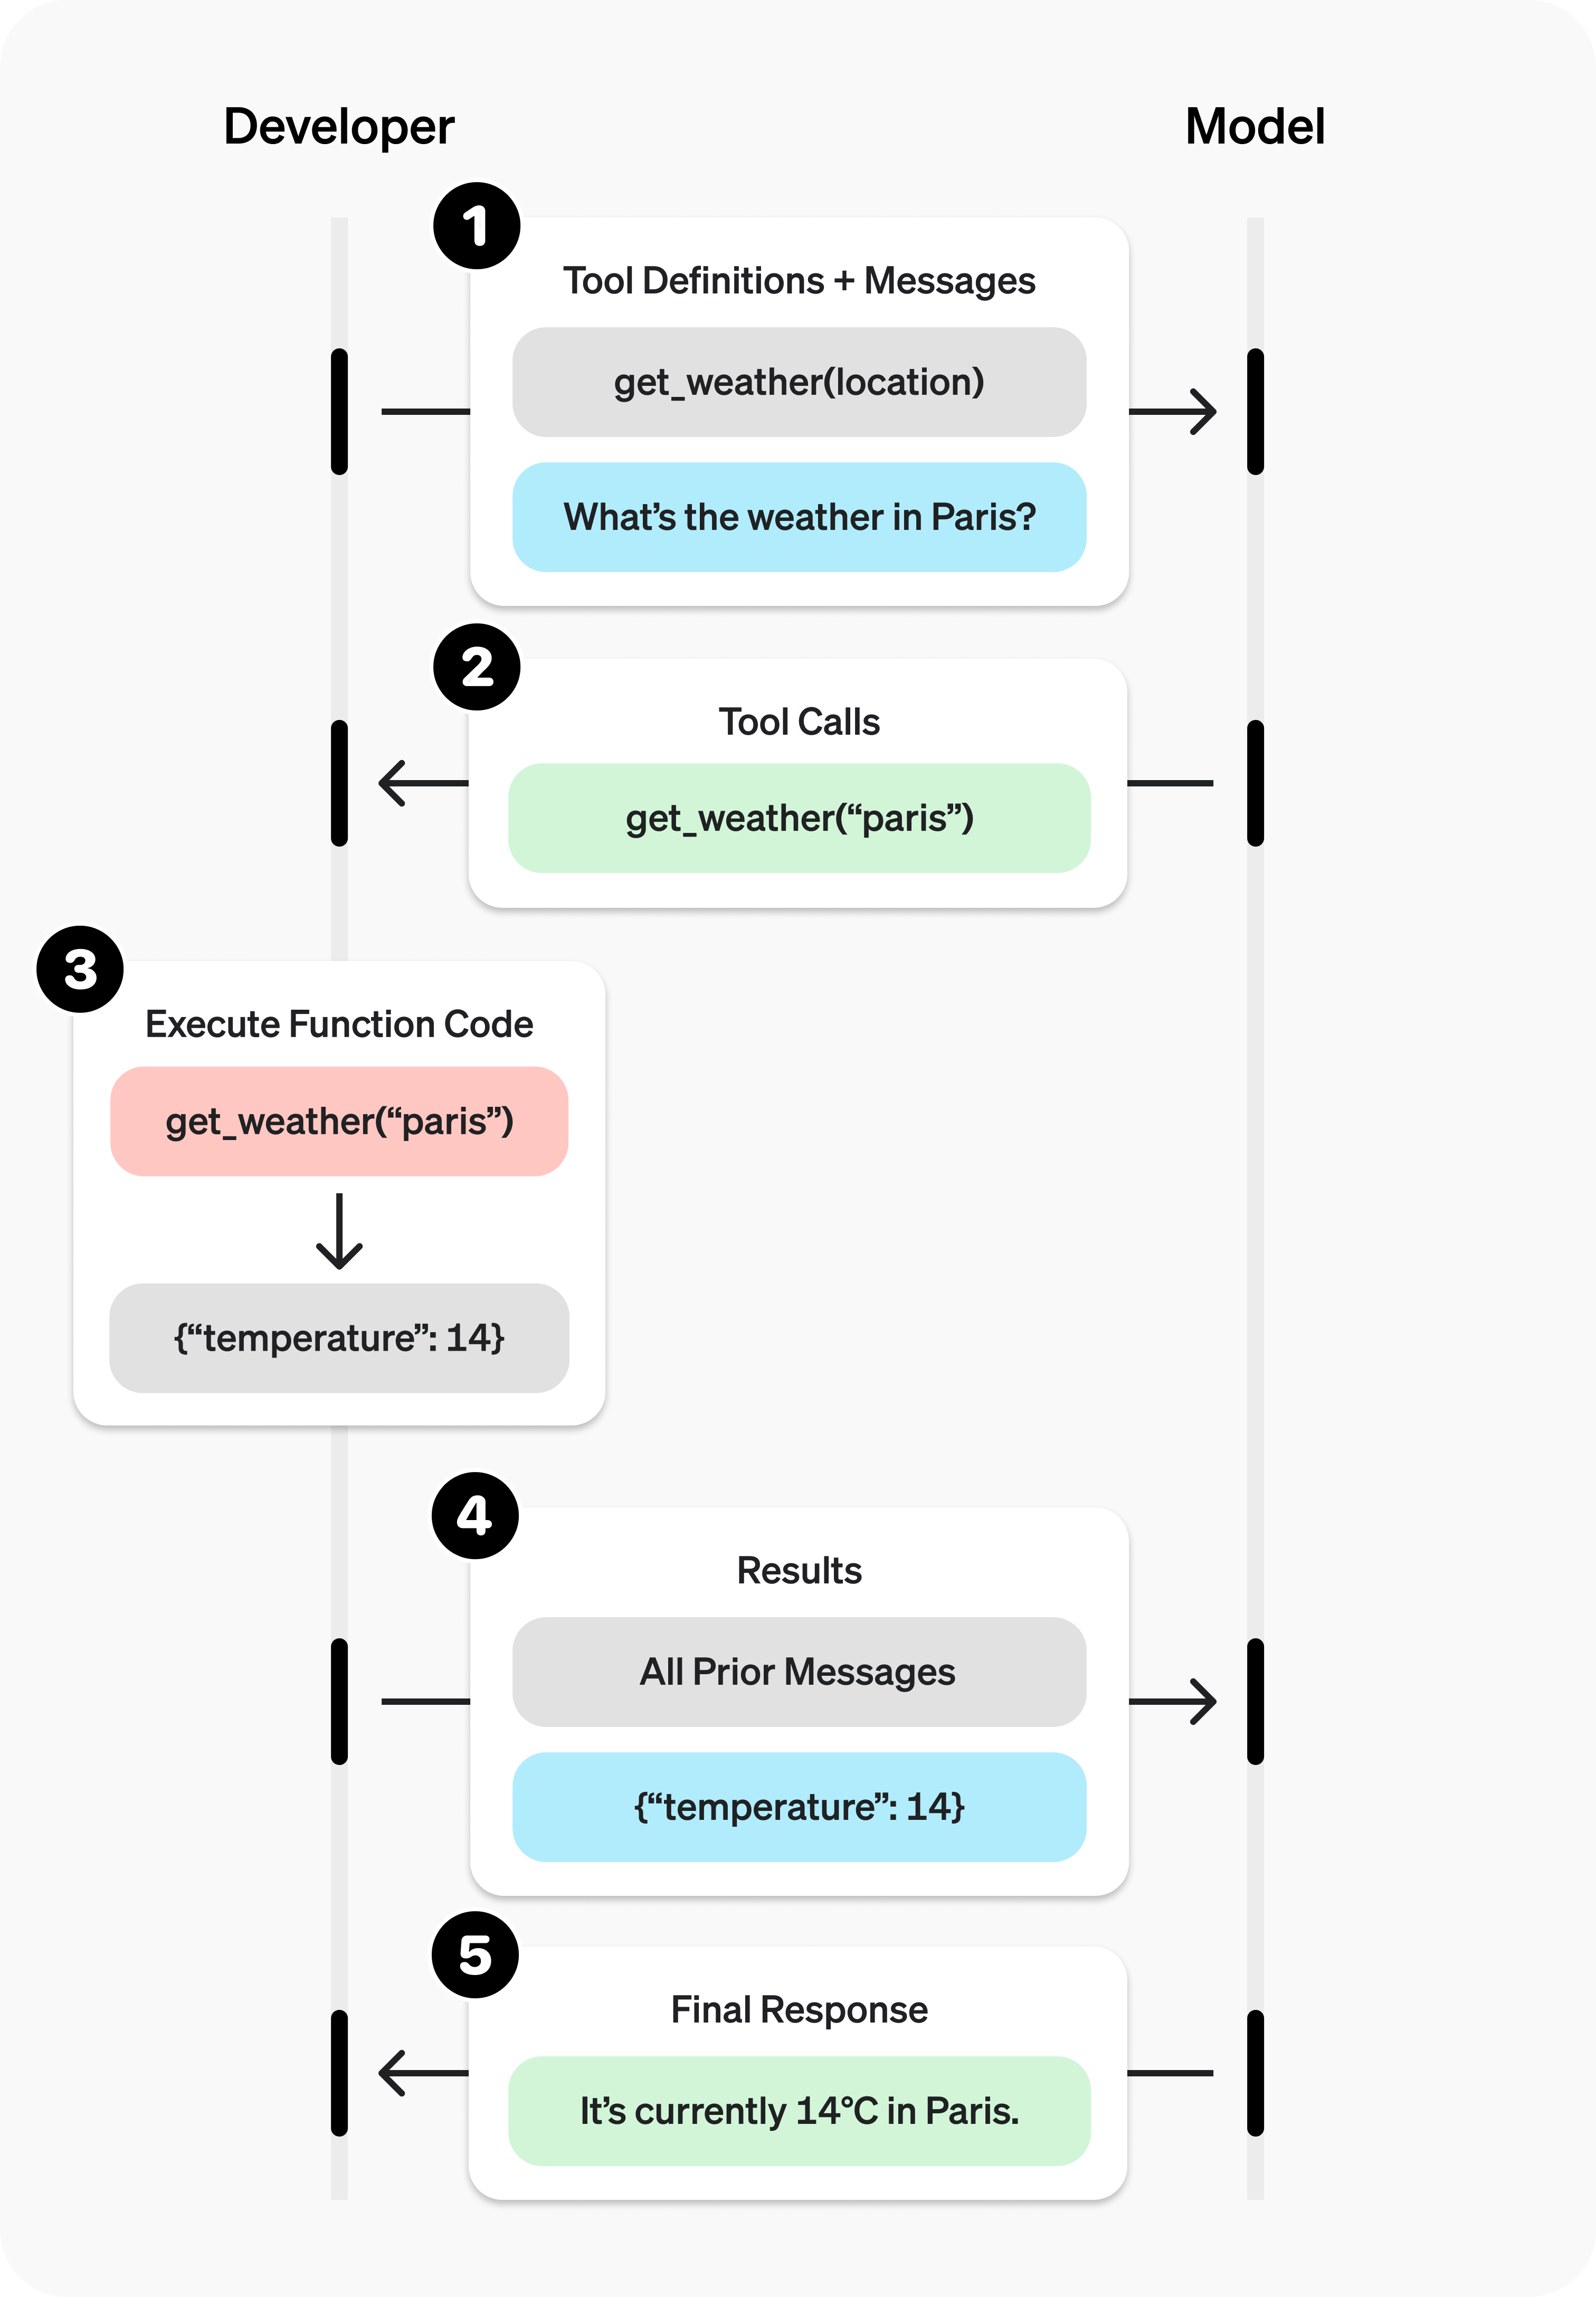

In [1]:
# ✅ Step 0 — Imports & client setup
from openai import OpenAI
import os
import json
from datetime import datetime, timedelta

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())




In [2]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
model_name = "gpt-4o-mini"  # supports tool calling

## Step 1 — Define Python functions (our tools)

We define **two tools**:
- `get_weather` — returns fake weather data for a city
- `get_meeting_slots` — returns some available meeting times


In [4]:
def get_weather(location: str, unit: str = "celsius") -> dict:
    """Dummy weather function — replace with real API in production."""
    return {
        "location": location,
        "unit": unit,
        "temperature": 28 if unit == "celsius" else 82,
        "condition": "sunny with light breeze",
    }


def get_meeting_slots(days_ahead: int = 1) -> list[dict]:
    """Return some fake time slots for a meeting scheduler."""
    base = datetime.utcnow() + timedelta(days=days_ahead)
    slots = []
    for hour in (9, 11, 15):
        dt = base.replace(hour=hour, minute=0, second=0, microsecond=0)
        slots.append({
            "start_utc": dt.isoformat() + "Z",
            "duration_minutes": 30,
        })
    return slots

def dispatch_tool(name: str, arguments: dict):
    if name == "get_weather":
        return get_weather(**arguments)
    elif name == "get_meeting_slots":
        return get_meeting_slots(**arguments)
    else:
        raise ValueError(f"Unknown tool: {name}")

## Step 2 — Expose the tools to the model (JSON schema)

We describe the functions using the `tools` parameter.

Each tool is a dictionary with:
- `type`: always `"function"` for custom functions
- `name`: the function name
- `description`: natural language description
- `parameters`: JSON schema defining the function's input arguments


Best practices for function definition https://platform.openai.com/docs/guides/function-calling#best-practices-for-defining-functions

* Use clear, well-named functions with precise parameter and output descriptions, including when they should or shouldn’t be used.

* Follow software engineering best practices: intuitive design, valid input structures etc

* Reduce burden on the model by avoiding unnecessary parameters and combining sequential operations.

* Keep the function set small (ideally under ~20) 

In [5]:



tools = [
    {
        "type": "function",
        "name": "get_weather",
        "description": "Get the weather for a location.",
        "parameters": {
            "type": "object",
            "properties": {
                "location": {
                    "type": "string",
                    "description": "City and country, e.g., 'Chennai, India'"
                },
                "unit": {
                    "type": "string",
                    "enum": ["celsius", "fahrenheit"],
                    "description": "Temperature unit"
                }
            },
            "required": ["location"]
        }
    },
    {
        "type": "function",
        "name": "get_meeting_slots",
        "description": "Suggest available meeting time slots.",
        "properties": {
            "type": "object",
            "properties": {
                "days_ahead": {
                    "type": "integer",
                    "default": 1,
                    "description": "How many days ahead to check availability"
                }
            }
        }
    }
]


## Step 3 — Ask a question that may require multiple tools

We now send a request where the model can decide **which tool(s)** to call.

Example question:
> "I am in Chennai tomorrow. What's the weather like and give me 2 good meeting slots in the afternoon?"


In [6]:
user_query = (
    "I am in Chennai tomorrow afternoon. "
    "Tell me what the weather will be like, and suggest 2 good 30‑minute meeting slots."
)

input_list = [{"role": "user", "content": user_query}]

response = client.responses.create(
    model=model_name,
    input=input_list,
    tools=tools,
   # tool_choice="required",  # let the model decide which tools (if any) to call
)

print("Raw response object (truncated):")
print(str(response)[:1000])

Raw response object (truncated):
Response(id='resp_0f06e1149e56156c00692d45711e608193a5739ca88c15aa77', created_at=1764574577.0, error=None, incomplete_details=None, instructions=None, metadata={}, model='gpt-4o-mini-2024-07-18', object='response', output=[ResponseFunctionToolCall(arguments='{"location":"Chennai, India","unit":"celsius"}', call_id='call_bgxtM5MX7TMXW065zrRCu0Vk', name='get_weather', type='function_call', id='fc_0f06e1149e56156c00692d4572569881939c6a8fa8681e52fe', status='completed'), ResponseFunctionToolCall(arguments='{}', call_id='call_2mDZmpgXKsEI2E1ZKaVutIP9', name='get_meeting_slots', type='function_call', id='fc_0f06e1149e56156c00692d4572c1988193b4be7215a9cdf892', status='completed')], parallel_tool_calls=True, temperature=1.0, tool_choice='auto', tools=[FunctionTool(name='get_weather', parameters={'type': 'object', 'properties': {'location': {'type': 'string', 'description': "City and country, e.g., 'Chennai, India'"}, 'unit': {'type': 'string', 'enum': ['celsiu

### Step 4 — Inspect tool calls

When the model decides to use tools, the first response will contain **tool calls** instead of a
final natural‑language answer.

In the Responses API, you inspect `response.output` to see what the assistant returned.

We will:
- Look at the first message in `response.output`
- Check whether it contains any tool calls (depending on SDK version this may appear as
  special objects inside `content` or as a `tool_calls` attribute).

👉 Run the cell below and visually inspect the structure in your environment; it can change slightly
between SDK versions, but the pattern is the same: **model proposes tool name + JSON arguments**.

In [7]:
first_msg = response.output[0]
print(first_msg)

# Save function call outputs for subsequent requests
input_list += response.output


ResponseFunctionToolCall(arguments='{"location":"Chennai, India","unit":"celsius"}', call_id='call_bgxtM5MX7TMXW065zrRCu0Vk', name='get_weather', type='function_call', id='fc_0f06e1149e56156c00692d4572569881939c6a8fa8681e52fe', status='completed')


In [8]:
tool_calls = [
    item for item in response.output 
    if hasattr(item, "type") and item.type == "function_call"
]

print(tool_calls)

[ResponseFunctionToolCall(arguments='{"location":"Chennai, India","unit":"celsius"}', call_id='call_bgxtM5MX7TMXW065zrRCu0Vk', name='get_weather', type='function_call', id='fc_0f06e1149e56156c00692d4572569881939c6a8fa8681e52fe', status='completed'), ResponseFunctionToolCall(arguments='{}', call_id='call_2mDZmpgXKsEI2E1ZKaVutIP9', name='get_meeting_slots', type='function_call', id='fc_0f06e1149e56156c00692d4572c1988193b4be7215a9cdf892', status='completed')]


In [9]:


for call in tool_calls:
    name = call.name
    args = json.loads(call.arguments)  # now args should NOT be empty

    # 3. Execute the function logic for get_horoscope
    result = dispatch_tool(name, args)
   
     # 4. Provide function call results to the model
    input_list.append({
        "type": "function_call_output",
        "call_id": call.call_id,
        "output": json.dumps({
          "weather": result
        })
    })
   

response = client.responses.create(
    model=model_name,
    instructions="Respond only with a weather report generated by a tool.",
    tools=tools,
    input=input_list,
)



# 5. The model should be able to give a response!
print("Final output:")
print(response.model_dump_json(indent=2))
print("\n" + response.output_text)




C:\Users\vyanktesh.l\AppData\Local\Temp\ipykernel_43372\3834956073.py:13: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  base = datetime.utcnow() + timedelta(days=days_ahead)


Final output:
{
  "id": "resp_0f06e1149e56156c00692d4589049c81938d5b2b810ffdc09c",
  "created_at": 1764574601.0,
  "error": null,
  "incomplete_details": null,
  "instructions": "Respond only with a weather report generated by a tool.",
  "metadata": {},
  "model": "gpt-4o-mini-2024-07-18",
  "object": "response",
  "output": [
    {
      "id": "msg_0f06e1149e56156c00692d4589d1f48193be198214c22763ba",
      "content": [
        {
          "annotations": [],
          "text": "### Weather in Chennai\n- **Temperature**: 28°C\n- **Condition**: Sunny with light breeze\n\n### Suggested Meeting Slots\n1. **09:00 AM - 09:30 AM UTC**\n2. **11:00 AM - 11:30 AM UTC** \n\nFeel free to choose one of these slots for your meeting!",
          "type": "output_text",
          "logprobs": []
        }
      ],
      "role": "assistant",
      "status": "completed",
      "type": "message"
    }
  ],
  "parallel_tool_calls": true,
  "temperature": 1.0,
  "tool_choice": "auto",
  "tools": [
    {
    

## generic dispatcher to Execute tools in Python and send results back

Here we sketch a **generic dispatcher**:

1. Read tool calls from the model response
2. For each tool call:
   - Parse the JSON arguments
   - Call the corresponding Python function
   - Create a `tool` message with the results
3. Call `client.responses.create` **again**, giving both the original conversation and the tool outputs
   so the model can respond to the user naturally.

Because the exact attribute names for tool calls can vary slightly, the code below includes
some defensive checks and comments — you may need to tweak `tool_calls` extraction to match
your SDK version.

In [11]:



def handle_tool_calls_and_answer(original_user_query: str, first_response):
    """Generic 2‑step tool‑calling loop.

    1) Inspect the first response for tool calls
    2) Execute tools in Python
    3) Call the model again with tool outputs to get final answer
    """
    # 1) Build initial messages list
    messages = original_user_query
    
    # Save function call outputs for subsequent requests
    messages += response.output

    # ⚠️ The snippet below is intentionally pseudo‑code-ish because the exact
    # shape of tool calls may differ. Adjust `tool_calls` extraction as needed.
    tool_calls = [item for item in response.output 
    if hasattr(item, "type") and item.type == "function_call"]
   
    if not tool_calls:
        print("No tool calls detected; returning first assistant message text.")
        return assistant_message

    
    for call in tool_calls:
        name = call.name
        args_json = call.arguments
        args = json.loads(args_json)
        result = dispatch_tool(name, args)
        
        messages.append({
        "type": "function_call_output",
        "call_id": call.call_id,
        "output": json.dumps({
          "content": result  })
        })

        

    

    followup = client.responses.create(
        model=model_name,
        input=messages,
    )
    return followup


In [12]:
user_query = (
    "I am in Chennai tomorrow afternoon. "
    "Tell me what the weather will be like, and suggest 2 good 30‑minute meeting slots."
)
input_list = [{"role": "user", "content": user_query}]

response = client.responses.create(
    model=model_name,
    input=input_list,
    tools=tools,
   # tool_choice="required",  # let the model decide which tools (if any) to call
)

In [13]:
# Example usage of the dispatcher loop
final_response = handle_tool_calls_and_answer(input_list, response)
try:
    print(final_response.output_text)
except Exception:
    print(final_response)

C:\Users\vyanktesh.l\AppData\Local\Temp\ipykernel_43372\3834956073.py:13: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  base = datetime.utcnow() + timedelta(days=days_ahead)


Tomorrow afternoon in Chennai, the weather will be sunny with a light breeze, and the temperature will be around 28°C.

For your meetings, here are two good 30-minute time slots:

1. **2:00 PM to 2:30 PM**
2. **3:00 PM to 3:30 PM**

Let me know if you need any further assistance!


In [14]:
final_response

Response(id='resp_00fae078ecd45af600692d471431108193a93d4791601d1213', created_at=1764574996.0, error=None, incomplete_details=None, instructions=None, metadata={}, model='gpt-4o-mini-2024-07-18', object='response', output=[ResponseOutputMessage(id='msg_00fae078ecd45af600692d4714951c8193a66043a2cfbd0257', content=[ResponseOutputText(annotations=[], text='Tomorrow afternoon in Chennai, the weather will be sunny with a light breeze, and the temperature will be around 28°C.\n\nFor your meetings, here are two good 30-minute time slots:\n\n1. **2:00 PM to 2:30 PM**\n2. **3:00 PM to 3:30 PM**\n\nLet me know if you need any further assistance!', type='output_text', logprobs=[])], role='assistant', status='completed', type='message')], parallel_tool_calls=True, temperature=1.0, tool_choice='auto', tools=[], top_p=1.0, background=False, conversation=None, max_output_tokens=None, max_tool_calls=None, previous_response_id=None, prompt=None, prompt_cache_key=None, reasoning=Reasoning(effort=None, 